In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from imblearn.over_sampling import SMOTE

# Load and preprocess the data
df = pd.read_csv("./combined_forest.csv")

In [2]:
# Load and preprocess the data
df = pd.read_csv("./combined_forest.csv")
min_max_values = df.drop(columns=['acq_date', 'deforested']).agg(['min', 'max'])

for column in df.columns:
    if column not in ['acq_date', 'deforested']:
        x_min = min_max_values.loc['min', column]
        x_max = min_max_values.loc['max', column]
        df[f'std_{column}'] = (df[column] - x_min) / (x_max - x_min)

df.drop(columns=['acq_date'], inplace=True)
df.rename(columns={'DEM': 'elevation'}, inplace=True)
df.rename(columns={'std_DEM': 'std_elevation'}, inplace=True)


In [3]:
# Handle missing values
df_cleaned = df.dropna()

In [4]:

# Separate features and target variable
X = df_cleaned.drop(columns=['deforested'])  # Features
y = df_cleaned['deforested']  # Target variable

In [5]:
# Check for class imbalance
print("Class distribution:")
print(df_cleaned['deforested'].value_counts())


Class distribution:
deforested
0    3532
1    1569
Name: count, dtype: int64


In [6]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


In [8]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [9]:
# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_1', min_value=32, max_value=256, step=32), input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('units_2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('units_3', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [10]:
# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='keras_tuner_dir',
    project_name='deforestation_tuning'
)

Reloading Tuner from keras_tuner_dir/deforestation_tuning/tuner0.json


In [11]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [12]:
# Run the tuner search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])


In [13]:
# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]


In [14]:
# Build the best model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)


/Users/chema./Documents/Programming/GuadaHack/MLmodel/ForestForecastML/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Train the best model and capture the history
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7140 - loss: 0.6939 - val_accuracy: 0.7382 - val_loss: 0.5594
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7518 - loss: 0.5359 - val_accuracy: 0.7958 - val_loss: 0.4563
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7708 - loss: 0.4984 - val_accuracy: 0.8123 - val_loss: 0.4354
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.4772 - val_accuracy: 0.8118 - val_loss: 0.4347
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7836 - loss: 0.4766 - val_accuracy: 0.8113 - val_loss: 0.4314
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7890 - loss: 0.4560 - val_accuracy: 0.8146 - val_loss: 0.4314
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7905 - loss: 0.4603 - val_accuracy: 0.8085 - val_loss: 0.4243
Epoch 8/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8033 - loss: 0.4451 - val_accu

In [16]:
# Evaluate the best model
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
confusion = confusion_matrix(y_test_classes, y_pred_classes)
classification_rep = classification_report(y_test_classes, y_pred_classes)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_rep)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
Accuracy: 0.84
Confusion Matrix:
[[801 259]
 [ 70 990]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1060
           1       0.79      0.93      0.86      1060

    accuracy                           0.84      2120
   macro avg       0.86      0.84      0.84      2120
weighted avg       0.86      0.84      0.84      2120



In [17]:
# Calculate false negatives and false positives using the confusion matrix
tn, fp, fn, tp = confusion.ravel()

In [18]:
# Descriptive explanation
print("\nFalse Negatives: Instances where the model predicted 'not deforested' but the area was actually deforested.")
print("These are critical as they represent missed detections, which could lead to unmanaged deforestation.\n")

print("False Positives: Instances where the model predicted 'deforested' but the area was actually not deforested.")
print("These are less critical than false negatives but still problematic as they could lead to unnecessary resource allocation and alarm.\n")



False Negatives: Instances where the model predicted 'not deforested' but the area was actually deforested.
These are critical as they represent missed detections, which could lead to unmanaged deforestation.

False Positives: Instances where the model predicted 'deforested' but the area was actually not deforested.
These are less critical than false negatives but still problematic as they could lead to unnecessary resource allocation and alarm.



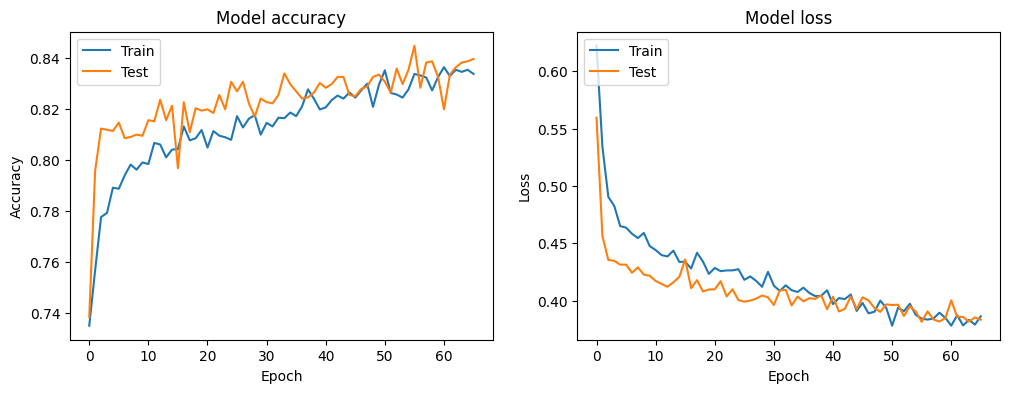

In [19]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()